In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sys
import statsmodels.api as sm
sys.path.append('../zdrojaky')
from tsplot import tsplot
import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Časové řady - velké repete

> **Definice**
>
> Časová řada je soubor pozorování (označených např. $x_t$) získaných v konkrétních časových okamžicích $t$.

Velmi nás zajímá, zda je časová řada **stacionární**. Postačíme si se **stacionaritou slabou**.

> Říkáme, že časová řada je slabě stacionární, pokud je invariantní vůči posunům v čase v rámci momentů rozdělení do druhého řádu, tj.
> 
$$\begin{aligned}
\mathbb{E}[X_t] &= \mu,\\
\operatorname{cov}(X_t, X_{t+\tau}) &= \gamma(\tau).
\end{aligned}
$$

## Dekompozice časové řady

   - **aditivní**: $Y_t = T_t + S_t + E_t$,
   - **multiplikativní**: $Y_t = T_t \cdot S_t \cdot E_t$,
   
kde $Y_t$ je pozorovaná veličina v čase $t$, $T_t$ je hodnota trendu, $S_t$ je sezónní složka a $E_T$ nevysvětlená složka (cyklické změny a nepravidelné fluktuace). V aditivních modelech obecně platí, že amplituda sezónních složek je přibližně stejná, zatímco v multiplikativních se s rostoucím trendem zvyšuje i sezónní amplituda (a naopak). 

V balíku `statsmodels` máme jednoduchou cestu k aditivní i multiplikativní dekompozici časové řady. Ale pozor, je použit jednoduchý MA filtr a dekompozice má daleko k dokonalosti. To můžeme ozkoušet na oblíbeném `airline-passengers` datasetu.

Vykreslíme si původní dataset a jeho ACF a PACF, potom dekompozici na trend, sezónní složky a rezidua, která opět analyzujeme ACF a PACF.

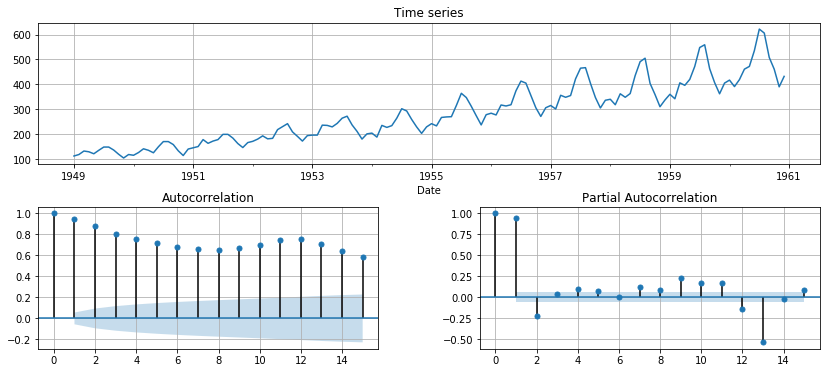

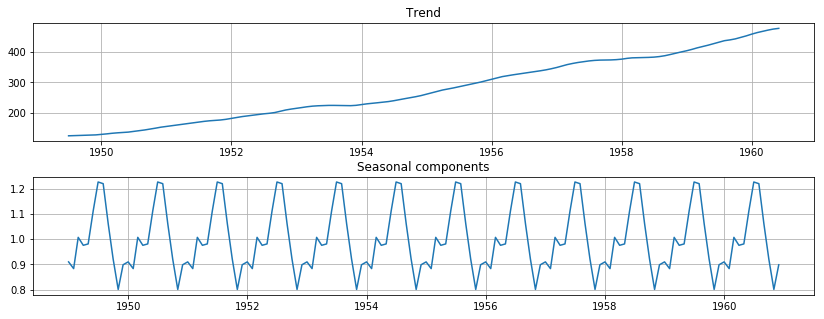

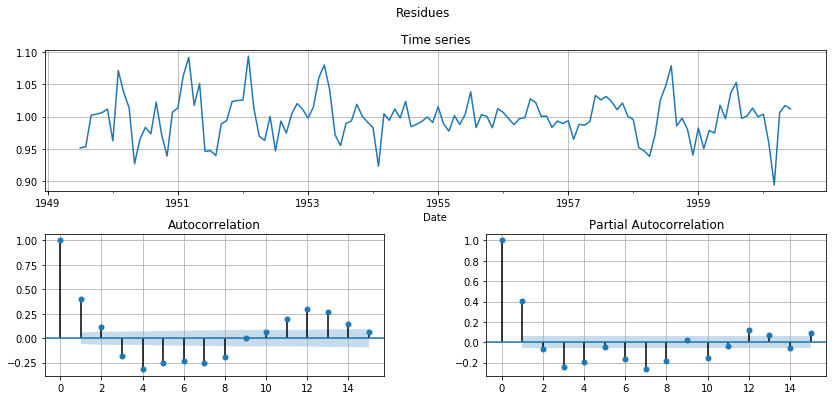

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('../zdrojaky/international-airline-passengers.csv', index_col=0, infer_datetime_format=True)
df.index = pd.to_datetime(df.index)

tsplot(df['Passengers'])
result = seasonal_decompose(df['Passengers'], freq=12, model='multiplicative')
plt.figure(figsize=(14,5))
plt.subplot(2,1,1)
plt.plot(result.trend)
plt.title("Trend")
plt.subplot(2,1,2)
plt.plot(result.seasonal)
plt.title("Seasonal components")
tsplot(result.resid.dropna())
plt.suptitle("Residues")
plt.show()

## Modely časových řad

### AR(p) modely
> **Autoregresním modelem** řádu $p$ nazýváme model
>
> $$
\begin{align}
Y_t &= c + \phi_1 Y_{t-1} + \ldots + \phi_p Y_{t-p} + \varepsilon_t \\
&= c + \sum_{\tau=1}^p \phi_\tau Y_{t-\tau} + \varepsilon_t \\
\end{align}
$$

> kde $c$ je konstanta (offset), $\phi_1, \ldots, \phi_p$ jsou koeficienty AR modelu a $\varepsilon_t$ je bílý šum.

AR modely mohou a nemusí být slabě stacionární.

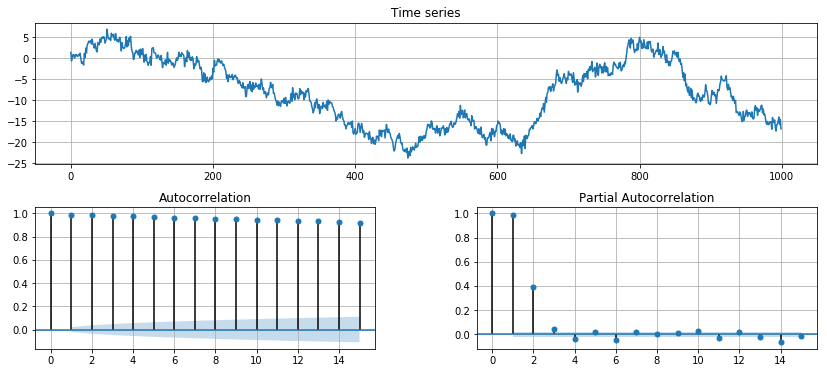

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 0)   Log Likelihood               -1438.698
Method:                       css-mle   S.D. of innovations              1.017
Date:                Wed, 06 Nov 2019   AIC                           2883.397
Time:                        08:52:01   BIC                           2898.120
Sample:                             0   HQIC                          2888.992
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5758      0.029     20.012      0.000       0.519       0.632
ar.L2.y        0.4213      0.029     14.637      0.000       0.365       0.478
                                    Roots           

In [3]:
ndat = 1000
y = np.zeros(ndat)
y[0:2] = (1.4, -1.2)
noise_std = 1
beta = [.6, .4]
for i in range(1, ndat):
    y[i] = np.dot(beta, [y[i-1], y[i-2]]) + np.random.normal(scale=noise_std)
tsplot(y)
plt.show()
model = sm.tsa.ARMA(y, order=(2,0))
result = model.fit(trend='nc')
print(result.summary())
data_AR = y    # Použijeme u kritérií níže

### MA(q) modely

> **Modely klouzavých průměrů**, Moving Average, řádu $q$ rozumíme model
>
>$$
Z_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q}, \qquad \varepsilon_t\sim\ \mathrm{iid}\ \mathcal{N}(0, \sigma^2),
$$

> kde $\theta_1,\ldots,\theta_q$ jsou MA koeficienty.

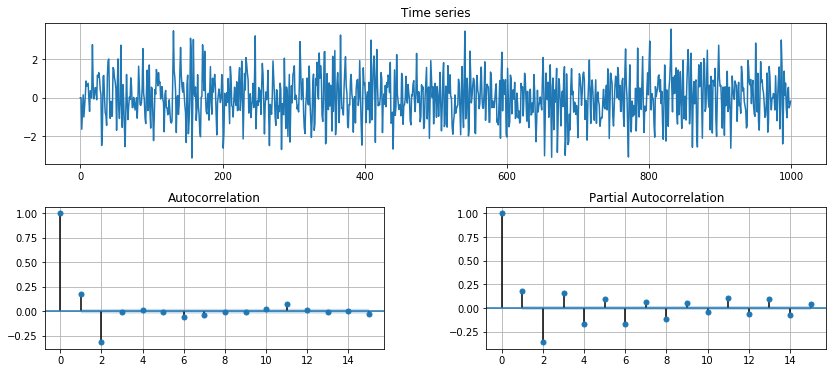

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 2)   Log Likelihood               -1401.433
Method:                       css-mle   S.D. of innovations              0.982
Date:                Wed, 06 Nov 2019   AIC                           2808.866
Time:                        08:52:01   BIC                           2823.589
Sample:                             0   HQIC                          2814.462
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.4249      0.029     14.767      0.000       0.369       0.481
ma.L2.y       -0.4489      0.029    -15.387      0.000      -0.506      -0.392
                                    Roots           

In [4]:
ndat = 1000
epsilon = np.random.normal(size=ndat)
y = np.zeros(ndat)
theta = [0.4, -.5]
mean = 0
for t in range(2, ndat):
    y[t] = mean + epsilon[t] + theta[0] * epsilon[t-1] + theta[1] * epsilon[t-2]
tsplot(y)
plt.show()
model = sm.tsa.ARMA(y, order=(0,2))
result = model.fit(trend='nc')
print(result.summary())

data_MA2 = y   # použijeme u kritérií

### ARMA(p,q) modely

ARMA modely jsou smíšené modely s AR(p) a MA(q) částí,

$$
\begin{aligned}
Y_t &= c + \phi_1 Y_{t-1} + \ldots + \phi_p Y_{t-p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \ldots + \theta_q \varepsilon_{t-q}, \qquad \varepsilon_t \sim \ \mathrm{iid}\ \mathcal{N}(0, \sigma^2) \\
&= c + \varepsilon_t + \sum_{i=1}^p \phi_i Y_{t-i} + \sum_{i=1}^q \theta_i \varepsilon_{t-i}
\end{aligned}
$$

a neznámými parametry jsou zde $c, \phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q, \sigma^2$.

### ARIMA(p,d,q) modely

Časové řady mohou vykazovat **trend**. Lineárního trendu se můžeme zbavit **diferencováním**, tj. počítáním **diferencí** řádu d=1,

$$
Y_t' = Y_t - Y_{t-1}.
$$

Vyšší diference použijeme pro nelineární trend. Obecně platí, že diferencujeme maximálně 2x, nemáme-li dostatečně dobrý důvod pro vyšší diference.

Výsledek potom modelujeme modelem **ARMA(p,q)**, tedy například ARIMA(p,1,q) je ARMA(p,q) na diferencích prvního řádu.

**AR charakteristika - zejména silná pro 1. lag - může značit poddiferencovanost časové řady, zatímco MA charakteristika přediferencovanost. Pokud je d>1, nepoužíváme v modelu konstantu c.**

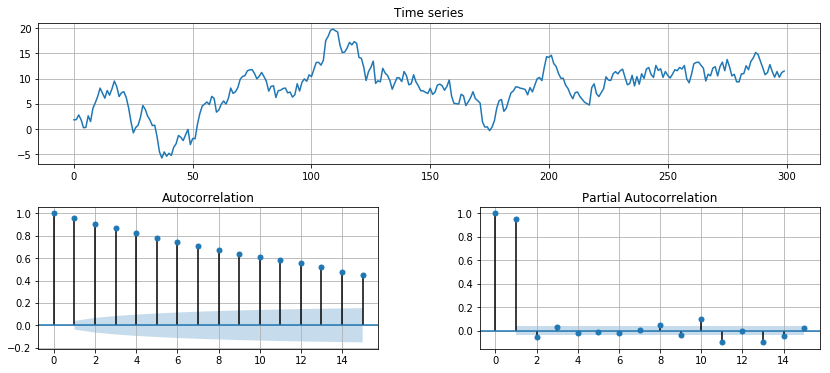

In [5]:
ndat = 300
d = 0
np.random.seed(123)  # pro stejná data při různých nastaveních
x_tmp = np.random.randint(-1, 2, size=ndat) + np.random.normal(size=ndat)
x = np.cumsum(x_tmp)
model = sm.tsa.ARIMA(x, order=(0,d,0))
tsplot(model.endog)

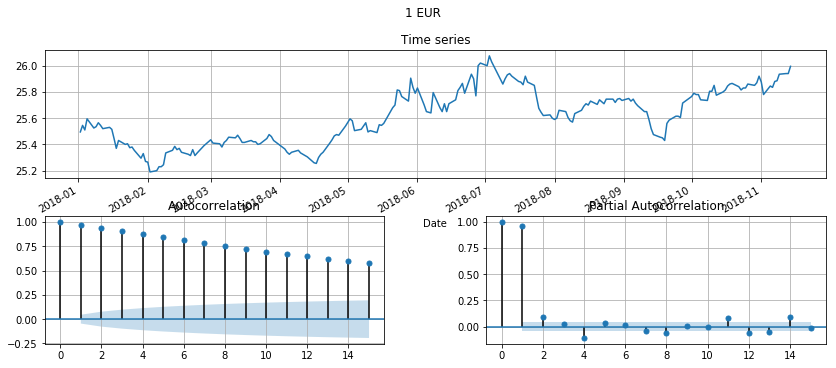

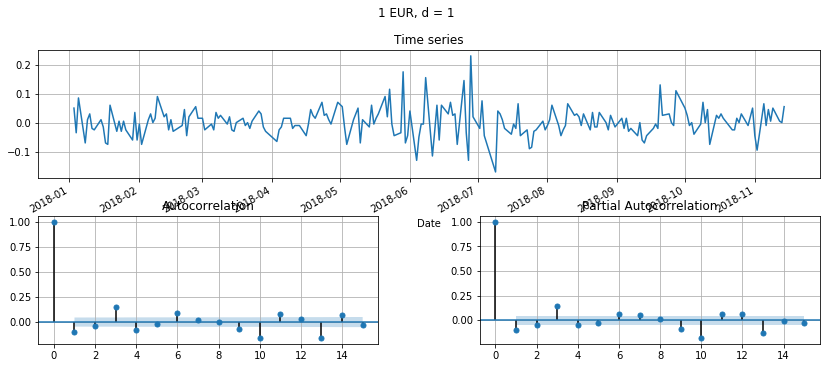

In [6]:
fn = '../zdrojaky/cnb2018.txt'
dfe = pd.read_csv(fn, index_col=0, sep='|')
dfe.index = pd.to_datetime(dfe.index)
tsplot(dfe['1 EUR'].dropna())
plt.suptitle('1 EUR')
plt.show()
tsplot(dfe['1 EUR'].diff(1).dropna())
plt.suptitle('1 EUR, d = 1')
plt.show()

### SARIMA(p,d,q)(P,D,Q)s modely

Sezónní modely ARIMA(p,d,q) s ARIMA(P,D,Q) charakteristikou opakující se s periodou sezónnosti $s$, typicky 4 (čtvrtletně) nebo 12 (ročně).

Např. SARIMA(0,0,1)(0,0,1)4 má tvar

$$
Y_t = \theta_1 \varepsilon_{t-1} + \varepsilon_t + \Theta_1(\theta_1 \varepsilon_{t-5} + \varepsilon_{t-4}).
$$

Takový model by šel napsat jako ARMA(0, 5) s nenulovými koeficienty pouze u zpoždění $t-1$, $t-4$ a $t-5$. Takhle ale máme koeficienty jen dva, $\theta_1, \Theta_1$.

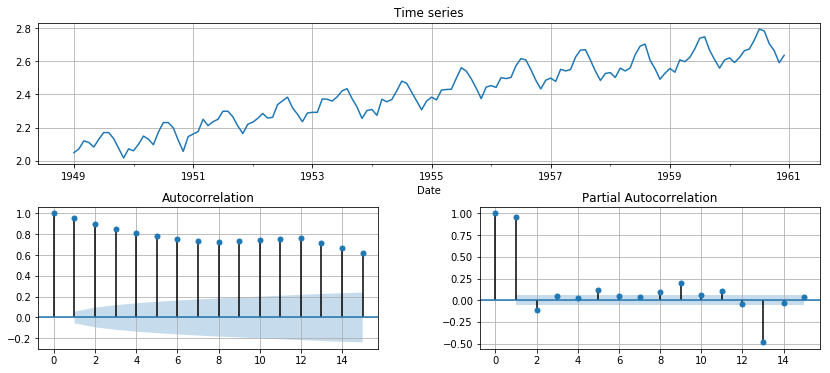

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 353.955
Date:                            Wed, 06 Nov 2019   AIC                           -701.909
Time:                                    08:52:05   BIC                           -693.000
Sample:                                01-01-1949   HQIC                          -698.289
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4024      0.073     -5.510      0.000      -0.546      -0.259
ma.S.L12      -0.5571      0.096   

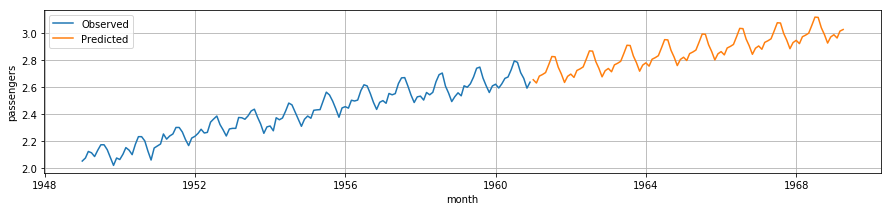

In [7]:
passengers = np.log10(df['Passengers'])
tsplot(passengers)
plt.show()
model = sm.tsa.SARIMAX(passengers, order=(0,1,1), seasonal_order=(0,1,1,12))
result = model.fit()
print(result.summary())
nsteps = 100
forecast = result.get_forecast(steps=nsteps)
plt.figure(figsize=(15,3))
plt.plot(passengers, label='Observed')
plt.plot(forecast.predicted_mean, label='Predicted')
plt.legend()
plt.xlabel('month')
plt.ylabel('passengers')
plt.show()

## Odhad modelů

1. **Klasický MLE odhad** - výpočetně náročný, vhodný pro standardní modely AR, MA, ARMA.
2. **MLE odhad se stavovou reprezentací** a počítáním věrohodnosti pomocí **Kalmanova filtru**
   - efektivní, rychlé
   - flexibilní, možnost nadefinovat prakticky libovolný stavový model
   - robustní při výpadcích dat
   - možné počítat i nelineární stavové modely
   - daň: horší intuice za stavovou reprezentací
   - většina softwaru fituje např. SARIMA tímto způsobem

## Výběr modelu

V první řadě fitujeme model podle charakteristických znaků - **ACF** a **PACF** (AR, MA, ARMA), přítomnosti **trendu** (diferencujeme). Pro výběr z několika potenciálně vhodných modelů používáme často jako kritéria AIC a BIC. Ať si vybereme jedno nebo druhé, vždy hledáme model s minimem kritéria. Může se stát, že každé z kritérií označí jako ideální jiný model.

#### AIC - [Akaikeho informační kritérium](https://en.wikipedia.org/wiki/Akaike_information_criterion)

Označme počet odhadovaných parametrů $k$ a maximální hodnotu věrohodnosti modelu $\mathcal{L}$. Potom kritérium je číslo

$$
\mathrm{AIC} = 2k - 2\ln \mathcal{L}.
$$

Kritérium je asymptoticky ekvivalentní ke křížové validaci.

#### BIC - [Bayesovské informační kritérium](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

Označme navíc počet pozorování $n$. Potom kritériem je číslo

$$
\mathrm{BIC} = k \ln(n) - 2\ln \mathcal{L}.
$$

In [8]:
sm.tsa.arma_order_select_ic(data_MA2, ic='aic')

{'aic':              0            1            2
 0  3117.447569  2986.319632  2809.826755
 1  3087.528427  2847.157775  2811.809454
 2  2950.290379  2823.762731  2812.513472
 3  2927.237153  2814.867955  2814.419366
 4  2899.668543  2816.113109  2815.238689, 'aic_min_order': (0, 2)}

In [9]:
sm.tsa.arma_order_select_ic(data_AR, ic='bic')

{'bic':              0            1            2
 0  6937.153362  5821.020303  5105.214540
 1  3088.781260  2919.371164  2905.539684
 2  2903.306888  2906.834821  2912.223496
 3  2906.123420  2909.073098  2915.914676
 4  2911.160051  2915.921192  2922.848344, 'bic_min_order': (2, 0)}

# Ex post analýzy

Každé modelování by mělo být završeno ex post analýzami, jejichž cílem je ověřit, že použitý model odpovídá předpokladům a že výsledky modelování mají rozumné vlastnosti. Kromě predikcí, jež jsou často cílem, se zaměřujeme na vlastnosti rezidují, zejména

- jejich rozdělení - je symetrické, centrované, připomíná normální rozdělení apod.?
- ACF a PACF - neobsahují rezidua nějakou zbývající charakteristiku typickou pro AR či MA modely?
- atd.

# Případová studie

Podívejme se na vývoj denních minimálních teplot v australském Melbourne v období 1981 - 1990.

In [10]:
fn = '../zdrojaky/daily-minimum-temperatures-in-me.csv'
df = pd.read_csv(fn, index_col=0, dtype={2:np.float64})
df.index = pd.to_datetime(df.index)
df.rename(columns={"Daily minimum temperatures in Melbourne, Australia, 1981-1990": 'Temp'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temp    3647 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


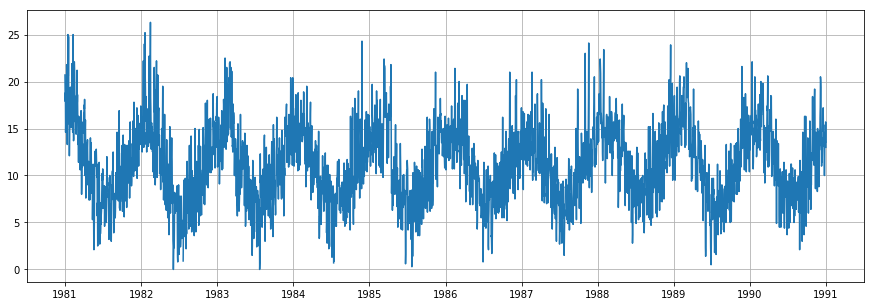

In [11]:
plt.figure(figsize=(15,5))
plt.plot(df['Temp'])
df.info()

Máme pro 10 let celkem 3650 měření. Podívejme se na jednu náhodně vybranou sezónu.

In [12]:
season = df['1985']
print(season.describe())

             Temp
count  365.000000
mean    11.137534
std      4.138998
min      0.300000
25%      8.000000
50%     11.000000
75%     14.300000
max     22.400000


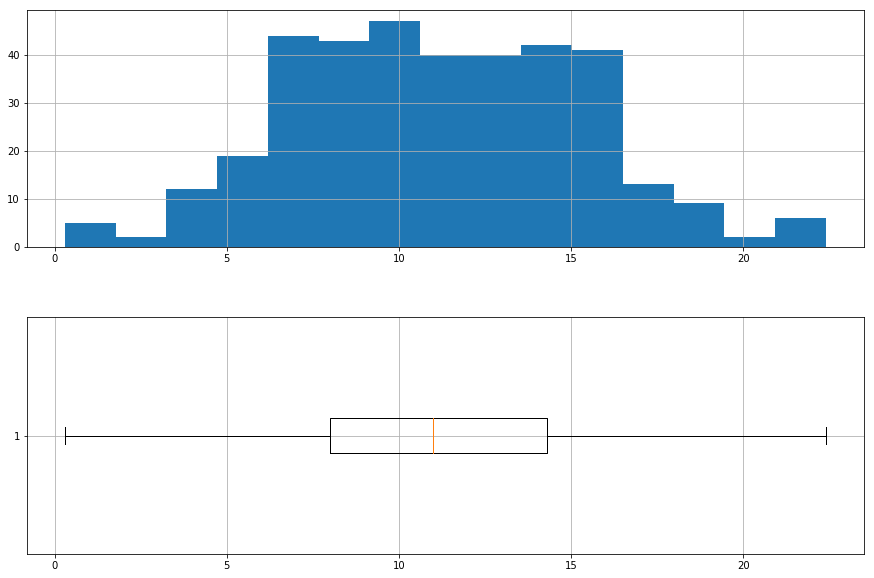

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.hist(season.values, bins=15)
plt.subplot(2,1,2)
plt.boxplot(season.values, vert=False)
plt.show()

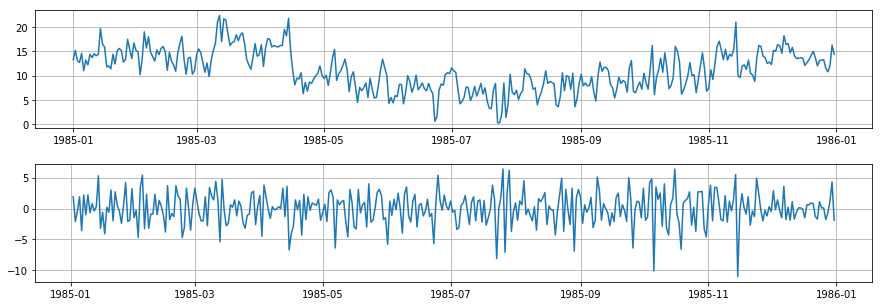

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(season)
plt.subplot(2,1,2)
plt.plot(season.diff(1))

Zdá se, že diferencování pomůže odstranit z časové řady trend. Zkusíme a podíváme se na statistiky diferencované řady.

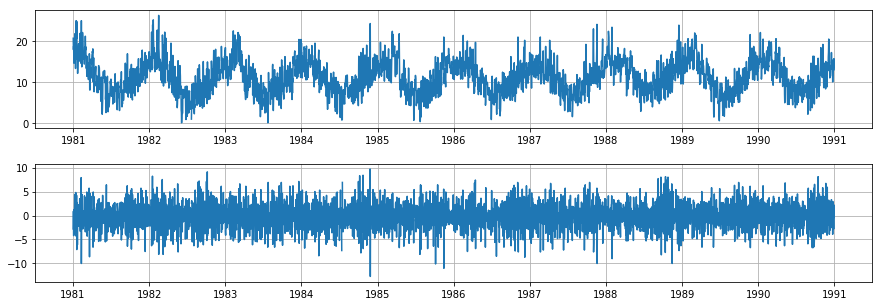

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(df)
plt.subplot(2,1,2)
plt.plot(df.diff(1))

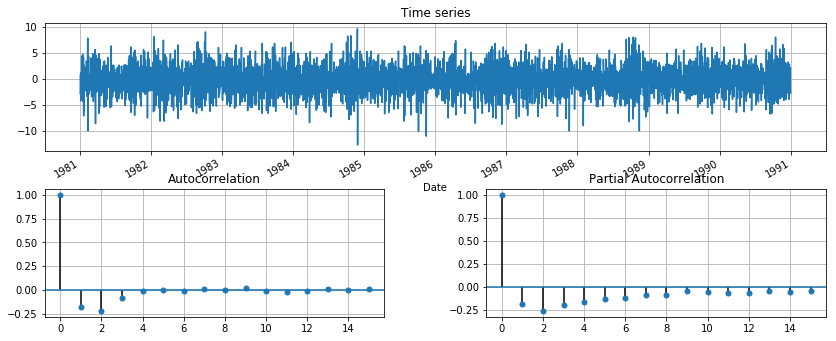

In [16]:
tsplot(df['Temp'].diff(1).dropna())

In [17]:
df.diff(1).describe()

,Temp
count,3644.000000
mean,-0.000988
std,2.732123
min,-12.700000
25%,-1.700000
50%,0.200000
75%,1.800000
max,9.700000


Jak vidíme, diferencování nás velmi přiblížilo k rozumně se chovající časové řadě s průměrem blízkým 0 a MA charakteristikou.

Pro další modelování už použijeme průměry za celé jednotlivé týdny (proč?).

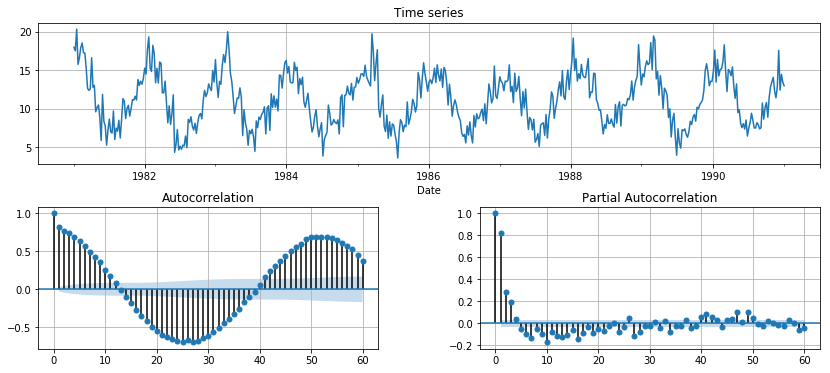

In [18]:
weekly_avgs = df['Temp'].resample('W').mean()
tsplot(weekly_avgs, 60)

Podíváme se opět na vývoj v jednom roce, neboť můžeme očekávat, že podle obrázku se to bude víceméně opakovat.

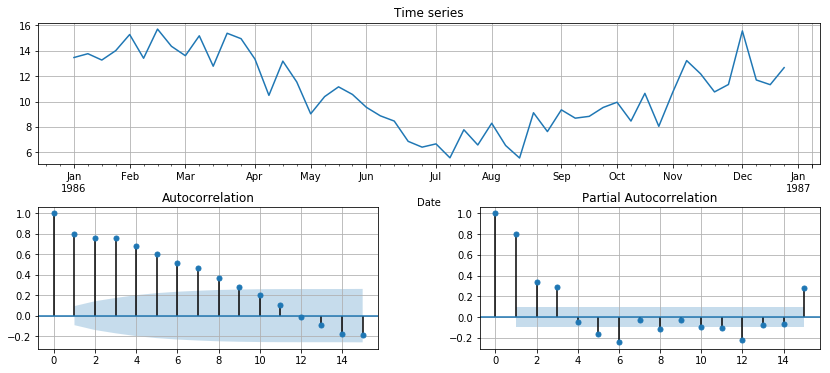

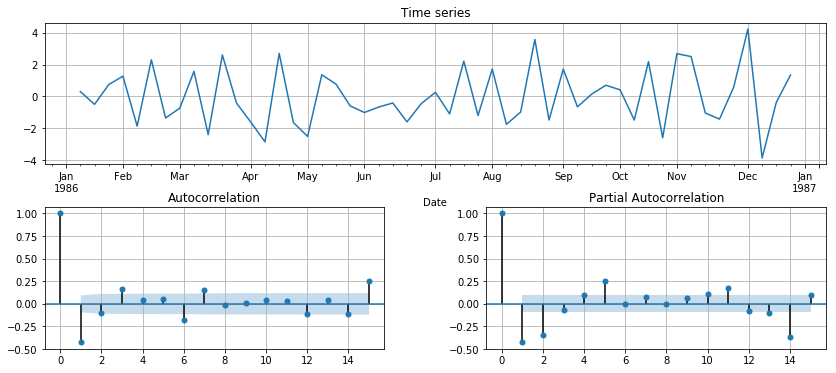

In [19]:
tsplot(weekly_avgs['1986'])
tsplot(weekly_avgs['1986'].diff(1).dropna())

In [20]:
sm.tsa.arma_order_select_ic(weekly_avgs['1986'].diff(1).dropna(), ic='aic')

{'aic':             0           1           2
 0  207.761960  195.770251  196.477549
 1  199.636431  197.307610  195.396666
 2  195.089484  197.016742  193.564584
 3  196.960930  198.339883  195.156678
 4  198.353032  198.495700  196.525955, 'aic_min_order': (2, 2)}

{'aic':              0            1            2
 0  2321.224544  2107.147388  2096.082313
 1  2250.611319  2097.625980  2097.443656
 2  2191.392042  2097.649422  2099.325871
 3  2163.382562  2098.866630  2100.655307
 4  2156.331018  2098.220424  2100.204479, 'aic_min_order': (0, 2)}

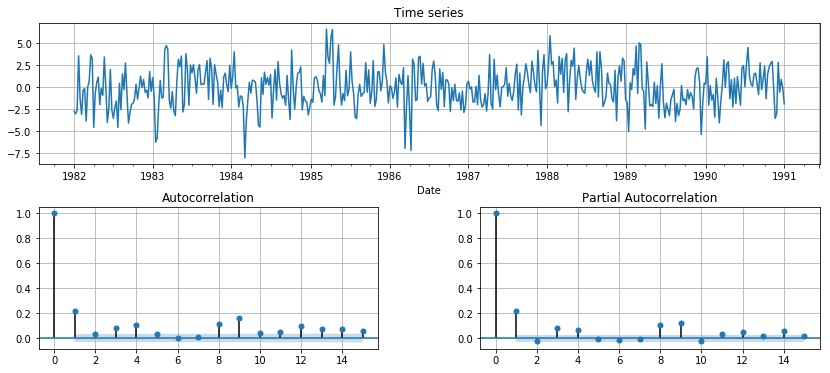

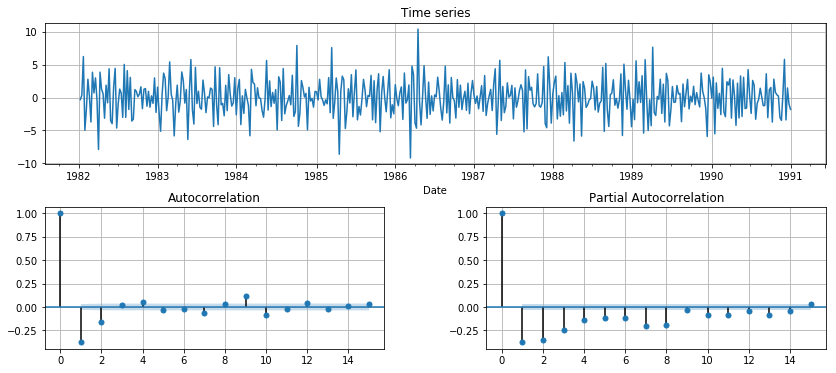

In [21]:
seasonal = weekly_avgs.diff(52).dropna()
tsplot(seasonal)
tsplot(seasonal.diff(1).dropna())
sm.tsa.arma_order_select_ic(seasonal.diff(1).dropna(), ic='aic')

In [22]:
model = sm.tsa.SARIMAX(weekly_avgs, order=(0,1,2), seasonal_order=(0,1,1,52))
result = model.fit(trend='nc')
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               Temp   No. Observations:                  523
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 52)   Log Likelihood                -948.459
Date:                            Wed, 06 Nov 2019   AIC                           1904.918
Time:                                    08:52:54   BIC                           1921.956
Sample:                                01-04-1981   HQIC                          1911.591
                                     - 01-06-1991                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7421      0.044    -16.956      0.000      -0.828      -0.656
ma.L2         -0.1881      0.045   

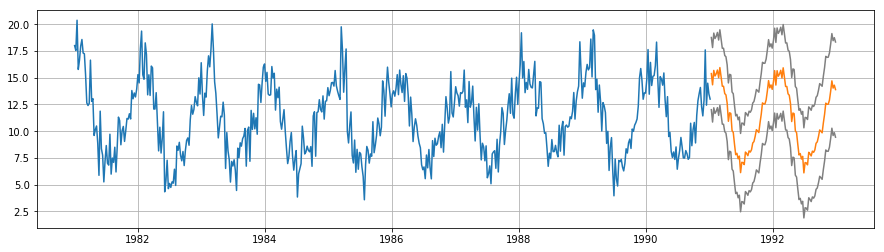

In [25]:
forecast_date = '1992'
forecast = result.get_forecast(forecast_date)
plt.figure(figsize=(15,4))
plt.plot(weekly_avgs)
plt.plot(forecast.summary_frame()['mean_ci_lower'], color='gray')
plt.plot(forecast.summary_frame()['mean'])
plt.plot(forecast.summary_frame()['mean_ci_upper'], color='gray')
plt.show()

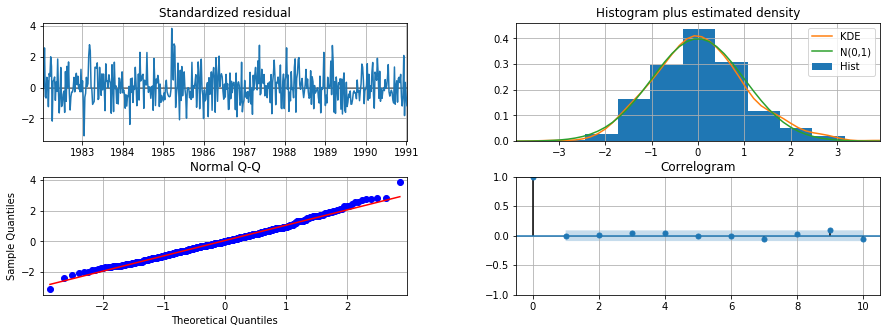

In [24]:
result.plot_diagnostics(figsize=(15,5))
plt.show()